# Price Optimisation Model

As stated in the equation below, **price elasticity of demand** measures how the demand for a product changes in response to a change in its price.

**Price Elasticity of Demand = (% Change in Quantity) / (% Change in Price)**

Understanding the relationship between price and demand enables companies to better predict customer behaviour and make more informed pricing decisions. This, in turn, allows businesses to optimise for profit by setting prices that balance demand with revenue goals.

This project aims to plot the **elasticity curve** of a specific product using historical data from a now-defunct online e-commerce store ([source](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)).

Once the elasticity curve is established, we will use it to model revenue scenarios and determine an optimal price point.

## Methodology

1. **Data Cleaning**  
   Remove inconsistencies, handle missing values, and prepare the data for analysis.

2. **Data Exploration**  
   Understand sales patterns, pricing behaviour, and demand characteristics.

3. **Product Selection and Exploration**  
   Choose a specific product with sufficient data for elasticity modelling and analyse the sales patterns.

4. **Elasticity Curve and Revenue Modelling**  
   Plot the elasticity curve and simulate revenue outcomes across different price points to identify the optimal pricing strategy.
5. **Results and Challenges**
   Analysing the results and discussing challenges faced along the way.


# Environment

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pygam import s,ExpectileGAM
from plotnine import * 


# Data Loading

In [3]:
cust=pd.read_csv('./braz_dataset/olist_customers_dataset.csv')
loc=pd.read_csv('./braz_dataset/olist_geolocation_dataset.csv')
order_i=pd.read_csv('./braz_dataset/olist_order_items_dataset.csv')
order_p=pd.read_csv('./braz_dataset/olist_order_payments_dataset.csv')
order_r=pd.read_csv('./braz_dataset/olist_order_reviews_dataset.csv')
order_d=pd.read_csv('./braz_dataset/olist_orders_dataset.csv')
prod_d=pd.read_csv('./braz_dataset/olist_products_dataset.csv')
seller=pd.read_csv('./braz_dataset/olist_sellers_dataset.csv')
product_tran=pd.read_csv('./braz_dataset/product_category_name_translation.csv')

# 1. Data Cleaning and Preprocessing

In [4]:
# add subjects to product
cat=prod_d[['product_id','product_category_name']]
cat=cat.merge(product_tran,on=['product_category_name'])
cat=cat.drop(columns=['product_category_name'])
cat=cat.rename(columns={'product_category_name_english':'product_category_name'})
order_i=order_i.merge(cat,on=['product_id'])
order_i.head() 
#formatting date
order_i['shipping_limit_date']=pd.to_datetime(order_i['shipping_limit_date'])
order_i=order_i.sort_values(by=['shipping_limit_date'])
order_i.head()

#clearing blanks 
# Get indices of blank rows
blank_indices = order_i[order_i.isna().all(axis=1)].index

# Count blank rows
num_blank_rows = len(blank_indices)


# Adding total sales
order_i=order_i.groupby(['order_id','product_id','seller_id','shipping_limit_date','price','freight_value','product_category_name']).agg('count').reset_index()
order_i=order_i.rename(columns={'order_item_id':'TOTAL_SALES'})
order_dm=order_d[['order_id','order_purchase_timestamp','order_status']]
order_i=order_i.merge(order_dm,on='order_id')

order_i['order_purchase_timestamp']=pd.to_datetime(order_i['order_purchase_timestamp'])


# filter for only delivered products
order_i=order_i.loc[order_i['order_status']=='delivered']
order_i=order_i.drop(columns=['order_status'])

# filter years with scarce data
order_i['order_id']=order_i['order_id'].astype('str')
order_i['order_purchase_timestamp']=pd.to_datetime(order_i['order_purchase_timestamp'])
order_i['MONTH_YEAR']= order_i['order_purchase_timestamp'].dt.to_period('M')
order_count=order_i.groupby(['MONTH_YEAR'])['order_id'].agg('count')



# 2. Data Exploration
> transactional data is from september 2016 to 2020 April

> over 112, 000 transactions over the period 

> 3067 original seller ids

> Data cleaned before 2017 and after 2018-08 due to the inconsistency of the quantity of the data and therefore the inability to understand its legitamacy

In [5]:
# basic stats
print(order_i['shipping_limit_date'].min())
print(order_i['shipping_limit_date'].max())

print(order_i['order_id'].count())
print(order_i['seller_id'].nunique())
print(order_i['product_id'].nunique())


2016-09-19 23:11:33
2020-04-09 22:35:08
98775
2912
31621


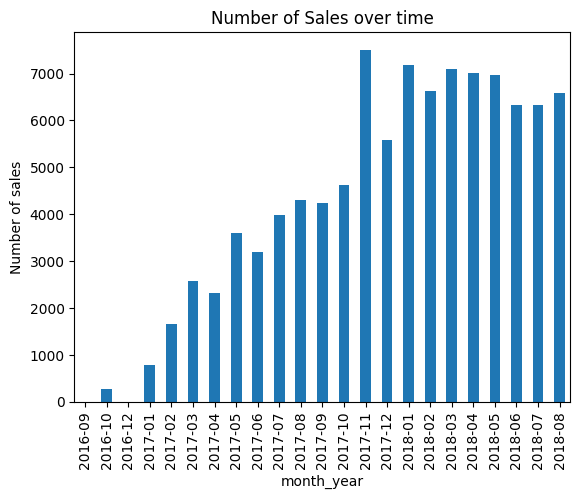

In [8]:

# Find number of products shipped over time
order_count.plot(kind='bar', y='values', legend=False)
plt.xlabel('month_year')
plt.ylabel('Number of sales')
plt.title('Number of Sales over time')
plt.savefig('./Graphs/Sales_overtime.png')

plt.show()

filt_yr=['2016-09','2016-10','2016-12','2018-09','2020-02','2020-04']
order_i['MONTH_YEAR']=order_i['MONTH_YEAR'].astype(str)
order_i=order_i.loc[~order_i['MONTH_YEAR'].isin(filt_yr)]

In [8]:
order_i['MONTH']= order_i['order_purchase_timestamp'].dt.month
order_i['YEAR']= order_i['order_purchase_timestamp'].dt.year
order_i['DATE']=order_i['order_purchase_timestamp'].dt.date

C:\Users\As-Pro\AppData\Local\Temp\ipykernel_1280\1327425338.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.


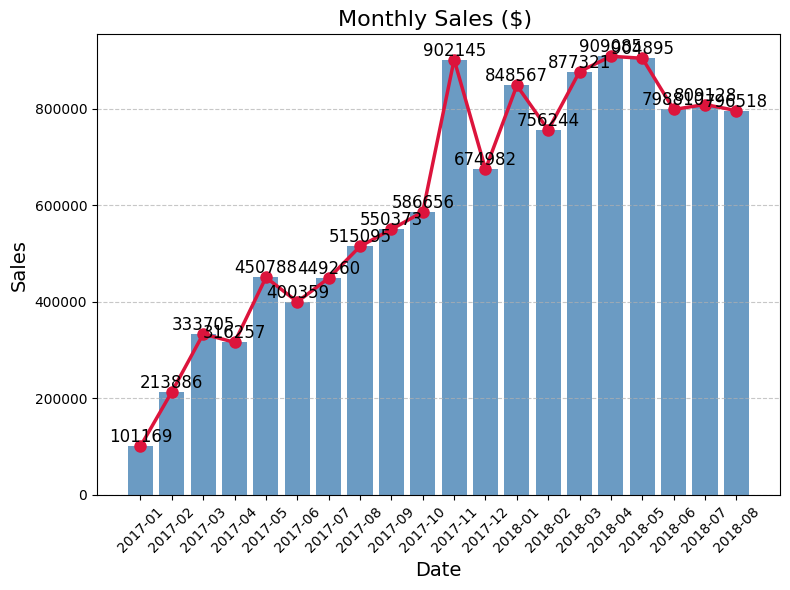

In [14]:
rev_count=order_i.groupby(['MONTH_YEAR'])['price'].agg('sum').reset_index()
rev_count=rev_count.rename(columns={'price':'REVENUE'})

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(rev_count['MONTH_YEAR'], rev_count['REVENUE'], color='steelblue', alpha=0.8)

plt.title('Monthly Sales ($) ', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Rotate x-axis tick labels
plt.xticks(rotation=45)

# Add a trendline connecting the tops of the bars
plt.plot(rev_count['MONTH_YEAR'], rev_count['REVENUE'], 'ro-', linewidth=2.5, markersize=8, color='crimson')

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.0f}',
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('./Graphs/Monthly_sales.png')
plt.show()

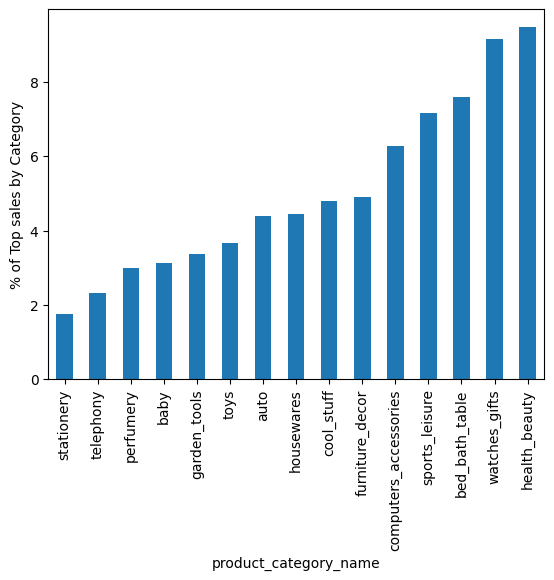

In [17]:
# Revenue by Category
revenue_by_category=order_i.groupby(['product_category_name'])['price'].agg('sum').sort_values()
revenue_by_category=(revenue_by_category/12507992.46)*100
top_rev=revenue_by_category.tail(15)
ax=top_rev.plot(kind='bar', y='percentage', legend=False,ylabel='% of Top sales by Category')
fig = ax.get_figure()
fig.savefig('./Graphs/revenue_by_cat.png', dpi=300, bbox_inches='tight')

# 3. Product Selection

The product selection is based on two key criteria:  
- The number of unique price points  
- The quantity of sales  

These factors ensure that the elasticity curve can be accurately populated and modeled.

Based on the data analysis, the product with ID `e0d64dcfaa3b6db5c54ca298ae101d05` has been selected for price optimisation. This product was chosen due to its sufficient number of unique prices and a high volume of orders, which provides a robust dataset for elasticity analysis.

This product is a **watch**, with prices ranging from **124.90** to **255.61**.


In [ ]:

selection=order_i.groupby(['product_id']).agg({'price':'nunique','order_id':'count'}).sort_values(by=['price']).tail(5)

print(selection)

                                  price  order_id
product_id                                       
656e0eca68dcecf6a31b8ececfabe3e8     23       111
6f3b5b605d91b7439c5e3f5a8dffeea7     23       116
e0d64dcfaa3b6db5c54ca298ae101d05     27       193
d285360f29ac7fd97640bf0baef03de0     29       118
437c05a395e9e47f9762e677a7068ce7     31       137


In [12]:
watch_pop=order_i.loc[order_i['product_id']=='e0d64dcfaa3b6db5c54ca298ae101d05']

## 3a. Product Analysis

Units sold have doubled after **February 2018**, driven by two main factors:  
1. An overall increase in website traffic, as observed during the initial data exploration.  
2. A decrease in average price over time.

When breaking the data down by seller, it becomes clear that seller `4869f7a5dfa277a7dca6462dcf3b52b2` played a key role in driving the price down after **January 2018**. This aggressive pricing strategy allowed them to capture the majority of the market share and effectively set a new market price for the product.


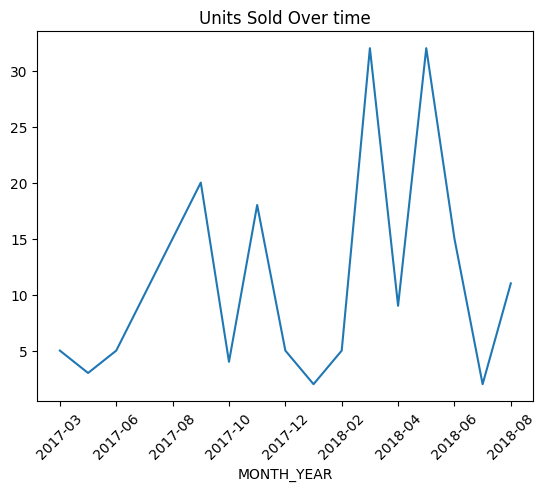

In [13]:
sales_over_time=watch_pop.groupby(['MONTH_YEAR'])['TOTAL_SALES'].agg('sum')
sales_over_time.plot()
plt.xticks(rotation=45)
plt.title('Units Sold Over time')
plt.show()

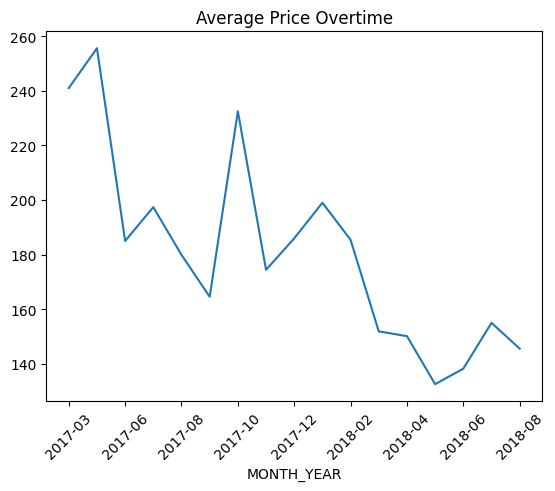

In [14]:
watch_pop.groupby(['MONTH_YEAR'])['price'].agg('mean').plot()
plt.xticks(rotation=45)
plt.title('Average Price Overtime')
plt.show()


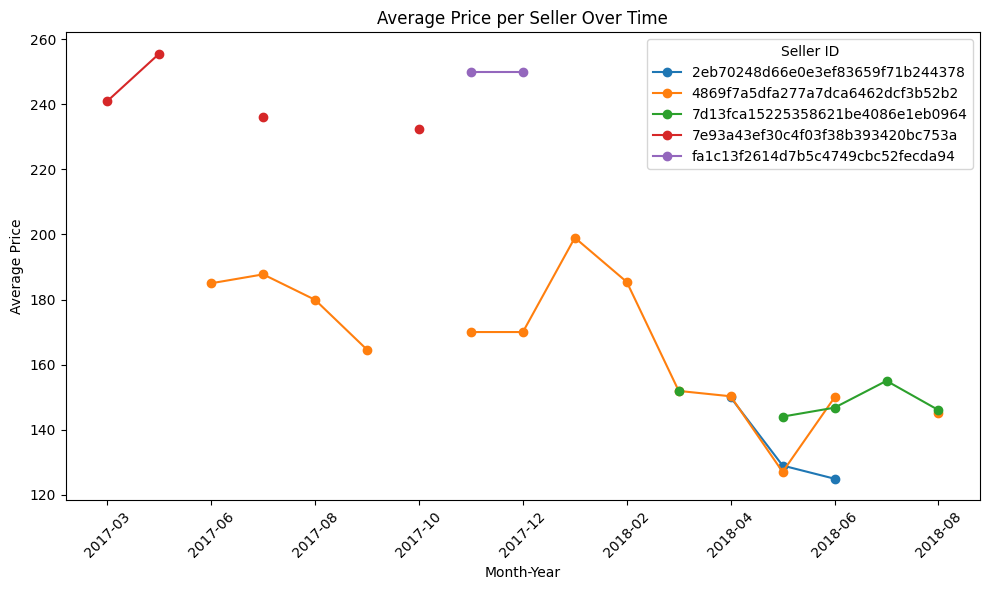

In [15]:
sell_price=watch_pop.groupby(['seller_id','MONTH_YEAR'])['price'].agg('mean').reset_index()
pivot = sell_price.pivot(index='MONTH_YEAR', columns='seller_id', values='price')

ax = pivot.plot(marker='o', figsize=(10, 6))

plt.xticks(rotation=45)

plt.title('Average Price per Seller Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Price')
plt.legend(title='Seller ID')

plt.tight_layout()
plt.show()

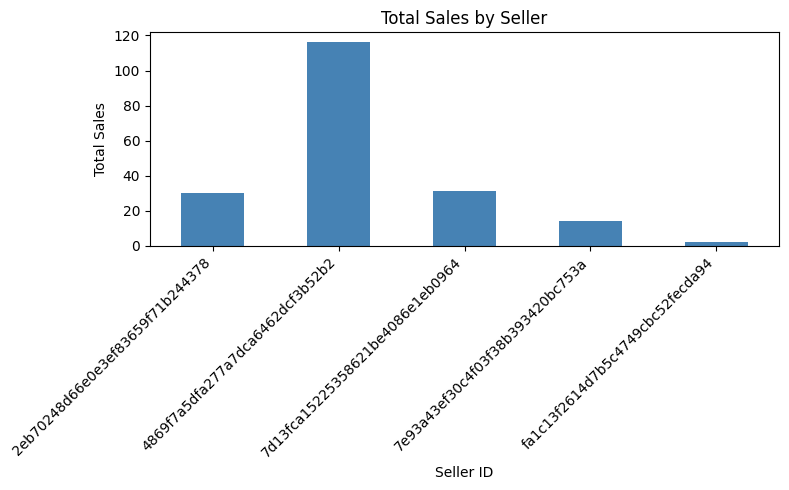

In [16]:
seller_sold=watch_pop.groupby(['seller_id'])['order_id'].agg('count')
ax = seller_sold.plot(kind='bar', x='seller_id', y='TOTAL_SALES', legend=False, color='steelblue', figsize=(8, 5))

plt.title('Total Sales by Seller')
plt.xlabel('Seller ID')
plt.ylabel('Total Sales')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 4. Elasticity Curve and Revenue Modelling

Expectile Generalized Additive Models (GAMs) are used to capture the relationship between **quantity demanded** and **price**. Unlike simple linear models, GAMs apply smooth, flexible curves to better represent non-linear relationships. 

Expectile GAMs use an **asymmetric squared loss**, allowing the model to focus on different parts of the distribution. This enables us to estimate not just the median relationship, but also **optimistic and pessimistic scenarios**. 

Specifically, we model the **0.025, 0.5 (median), and 0.975 expectiles**, representing:
- **Worst-case** demand response (0.025 expectile)
- **Typical** or median demand response (0.5 expectile)
- **Best-case** demand response (0.975 expectile)

This approach provides a comprehensive view of how quantity responds to price changes under varying conditions, which is crucial for accurate revenue modeling.

In [17]:
# create quantity over price table
scat_plot=watch_pop.groupby(['price'])['TOTAL_SALES'].agg('sum').reset_index()
# filter for outliers
scat_plot=scat_plot.loc[scat_plot['TOTAL_SALES']<20]

C:\Users\As-Pro\AppData\Local\Temp\ipykernel_12680\1006506866.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


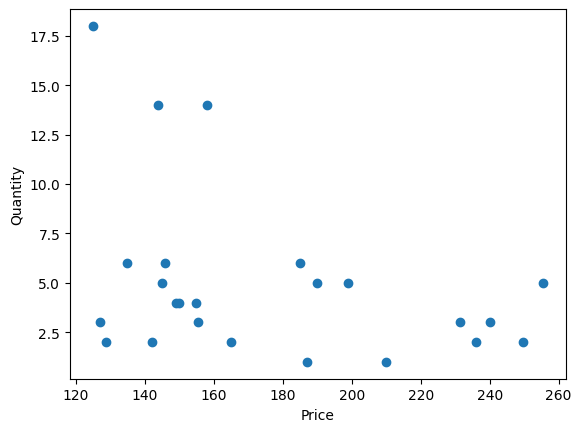

In [18]:
plt.scatter(scat_plot['price'],scat_plot['TOTAL_SALES'], cmap='viridis')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.show()

In [19]:
price=scat_plot[['price']]
num=scat_plot[['TOTAL_SALES']]

quantiles=[.025,.5,.975]

gam_results={}

for q in quantiles:
    gam=ExpectileGAM(s(0),expectile=q)
    gam.fit(price,num)
    gam_results[q]=gam
gam_results

{0.025: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.025, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False),
 0.5: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.5, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False),
 0.975: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.975, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False)}

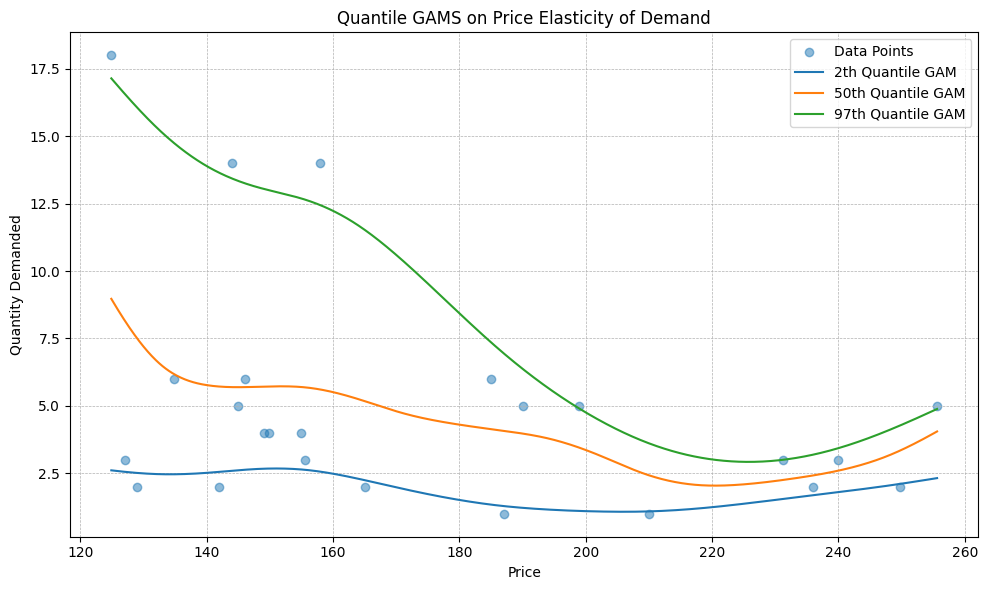

In [20]:
plt.figure(figsize=[10,6])
plt.scatter(scat_plot['price'],scat_plot['TOTAL_SALES'],alpha=.5,label='Data Points')

XX=np.linspace(scat_plot['price'].min(),scat_plot['price'].max(),1000).reshape(-1,1)
for q, gam in gam_results.items():
    plt.plot(XX,gam.predict(XX),label=f'{int(q*100)}th Quantile GAM')

plt.xlabel('Price')
plt.ylabel('Quantity Demanded')
plt.title('Quantile GAMS on Price Elasticity of Demand')

plt.legend()
plt.grid(True,which='both',linestyle='--',linewidth=.5)
plt.tight_layout()
plt.show()

In [ ]:
# gam predictions

quantiles=[.025,.5,.975]
gam_fit={}

for q in quantiles:
    gam=ExpectileGAM(s(0),expectile=q)
    gam.fit(price,num)
    gam_fit[f"pred_{q}"]= gam.predict(price)

predictions_gam=pd.DataFrame(gam_fit).set_index(price.index)

pred_conf=pd.merge(scat_plot,predictions_gam,left_index=True,right_index=True).sort_values(by=['price'])

pred_conf['REV_.025']=pred_conf['price']*pred_conf['pred_0.025']
pred_conf['REV_.5']=pred_conf['price']*pred_conf['pred_0.5']
pred_conf['REV_.975']=pred_conf['price']*pred_conf['pred_0.975']

pred_conf['ACTUAL_REVENUE']=pred_conf['price']*pred_conf['TOTAL_SALES']
pred_conf.head()

,pred_0.025,pred_0.5,pred_0.975
0,2.611133,8.969865,17.143545
1,2.556821,8.173775,16.576295
2,2.516156,7.530576,16.083077
3,2.465165,6.169194,14.731178
4,2.554666,5.717467,13.641358


In [23]:
# tv is the number of efficient points for revenue that could be chosen
tv=10

pred_conf=pred_conf.set_index(['price'])
best_025=pred_conf['REV_.025'].head(tv).reset_index()
best_5=pred_conf['REV_.5'].head(tv).reset_index()
best_975=pred_conf['REV_.975'].head(tv).reset_index()

pred_conf=pred_conf.reset_index()

price=pred_conf['price']
min=pred_conf['pred_0.025']
max=pred_conf['pred_0.975']
actual=pred_conf['pred_0.5']

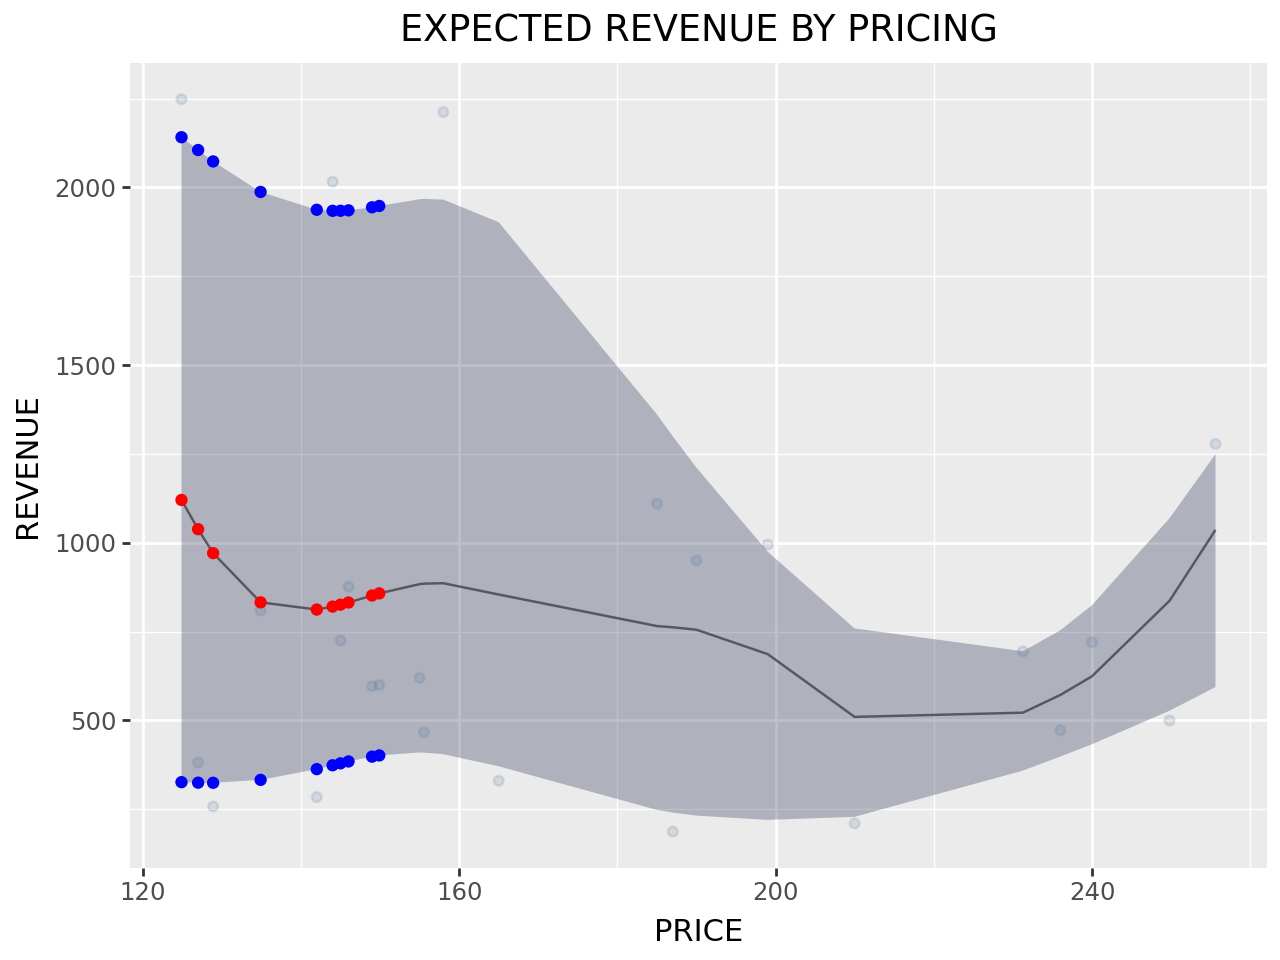

In [25]:
plot = (
    ggplot(pred_conf, aes(x='price', y='REV_.5'))
    + geom_ribbon(aes(ymin='REV_.025', ymax='REV_.975'), fill="#222e53", alpha=0.3)
    + xlab("PRICE")
    + ylab("REVENUE")
    + ggtitle("EXPECTED REVENUE BY PRICING")
    + geom_point(aes(y='ACTUAL_REVENUE'), color="#486D93", alpha=0.15)
    + geom_line(alpha=0.5)
    + geom_point(data=best_5, mapping=aes(x='price', y='REV_.5'), color="red")
    + geom_point(data=best_975, mapping=aes(x='price', y='REV_.975'), color="blue")
    + geom_point(data=best_025, mapping=aes(x='price', y='REV_.025'), color="blue")
    + theme(legend_position='none')
)

plot

## Results

Based on the top expected revenue scenarios modeled from the elasticity curve, the recommended pricing strategy moving forward — *ceteris paribus* — is to maintain prices within the **$120 to $160** range. Movements within this band should be responsive to the pricing behavior of competing sellers.

Since marginal costs were not included in this analysis, there is justification for favoring prices at the **higher end of the range** to maximize profit. However, demand is observed to shrink significantly at prices above **$160**, suggesting diminishing returns beyond this threshold.

---

## Challenges

### **1. Limited Data Availability**
The dataset covers a relatively short period — from **January 2017 to August 2018** — with total monthly sales peaking at approximately **7,000 units**, while the product in question had only **193 units sold across 27 distinct price points**. This created two key challenges:

- **Sparse coverage of the elasticity curve**, leading to high variability between worst-case, median, and best-case scenarios. This variability propagated into the expected revenue estimates.
- The absence of a stable market environment makes it difficult to confidently attribute changes in demand solely to price changes, rather than external factors like fluctuating customer traffic.

### **2. Lack of Marginal Cost Data**
Without information on marginal costs, it is impossible to accurately determine profit-maximizing price points. This limits the ability to provide a complete pricing recommendation. However, the analysis still identified price thresholds — notably prices above **$160** — where demand begins to drop sharply, informing upper boundaries for pricing decisions.

## Conclusion

This analysis provides a data-driven pricing recommendation based on demand elasticity modeling using expectile GAMs. Despite limitations in data coverage and the absence of marginal cost information, the findings suggest that maintaining prices within the **$120 to $160** range balances revenue maximization with demand sensitivity. 

The observed demand decline beyond **$160** sets a clear upper boundary, while movements within the recommended band should remain responsive to competitor pricing dynamics.

However, the limitations — including a small sample size, a short data timeframe, and the lack of cost data — mean that these recommendations should be viewed as directional rather than definitive. Future analysis incorporating a longer time horizon, stable market conditions, and cost structure data would enable more precise and confident pricing decisions.
